In [64]:
import os
import zipfile
import random
import shutil
from shutil import copyfile

import tensorflow as tf
import numpy as np
import matplotlib as plt
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from stn import spatial_transformer_network as transformer
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas

%precision 4

'%.4f'

## maybe use the layers.add function instead?

that way for the localization layer, we can get the shape of the last convolution layer and somehow add that to the into the transformer? I still don't get what that part is doing

In [38]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=(256,256,3)),
#     tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
#     tf.keras.layers.MaxPool2D(2,2),
#     tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
#     tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
#     tf.keras.layers.MaxPool2D(2,2),
#     tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
#     tf.keras.layers.MaxPool2D(2,2),
#     tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
#     tf.keras.layers.Flatten()
#     ])


# model.add(tf.keras.layers.Dense(1024, activation="relu"))

# model.add(tf.keras.layers.Dense(512, activation="relu"))

# model.add(tf.keras.layers.Dense(7, activation="softmax"))


In [39]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(20, (2,2), activation="relu", input_shape=(256,256,3), strides=2),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(50, (2,2), activation="relu", strides=2),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500, activation="relu"),
    tf.keras.layers.Dense(7, activation="softmax"),
])

In [40]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 128, 20)      260       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 20)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 50)        4050      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 50)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 500)               6400500   
_________________________________________________________________
dense_10 (Dense)             (None, 7)                

In [41]:

model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['acc'])

In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = "emotions/train/"
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, target_size=(256,256), 
batch_size=32, class_mode="categorical")

VALIDATION_DIR = "emotions/validation/"
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, target_size=(256,256),batch_size=32, class_mode="categorical")



Found 26738 images belonging to 7 classes.
Found 3361 images belonging to 7 classes.


Bonnie_surprise_1389 image was corrupt, had to be removed

In [43]:
check_points = "checkpoint/checkpoint.hb/"
check_point_dir = os.path.dirname(check_points)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=check_point_dir, verbose=1)

In [54]:
# Load saved model
model = tf.keras.models.load_model("checkpoint/checkpoint.hb/")

In [53]:
history = model.fit(train_generator,
                            epochs=3,
                            verbose=1,  
                            validation_data=validation_generator,
                            callbacks=[cp_callback])


Epoch 1/3
  8/836 [..............................] - ETA: 4:29 - loss: 0.5128 - acc: 0.8164

KeyboardInterrupt: 

In [56]:
# Only Run this code if you want to overwrite the old model
# model.save("saved/model_folder.hb", overwrite=True)

INFO:tensorflow:Assets written to: saved/model_folder.hb\assets


In [ ]:
# Load saved model
# saved_model = tf.keras.models.load_model("saved/saved_model.hb/")

In [63]:

test_dir = "emotions/test/"
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_dir, target_size=(256,256), 
batch_size=32, class_mode="categorical")

model.evaluate(test_generator)

Found 3343 images belonging to 7 classes.
105/105 [==============================] - 7s 70ms/step - loss: 0.2862 - acc: 0.8989


[0.286, 0.899]

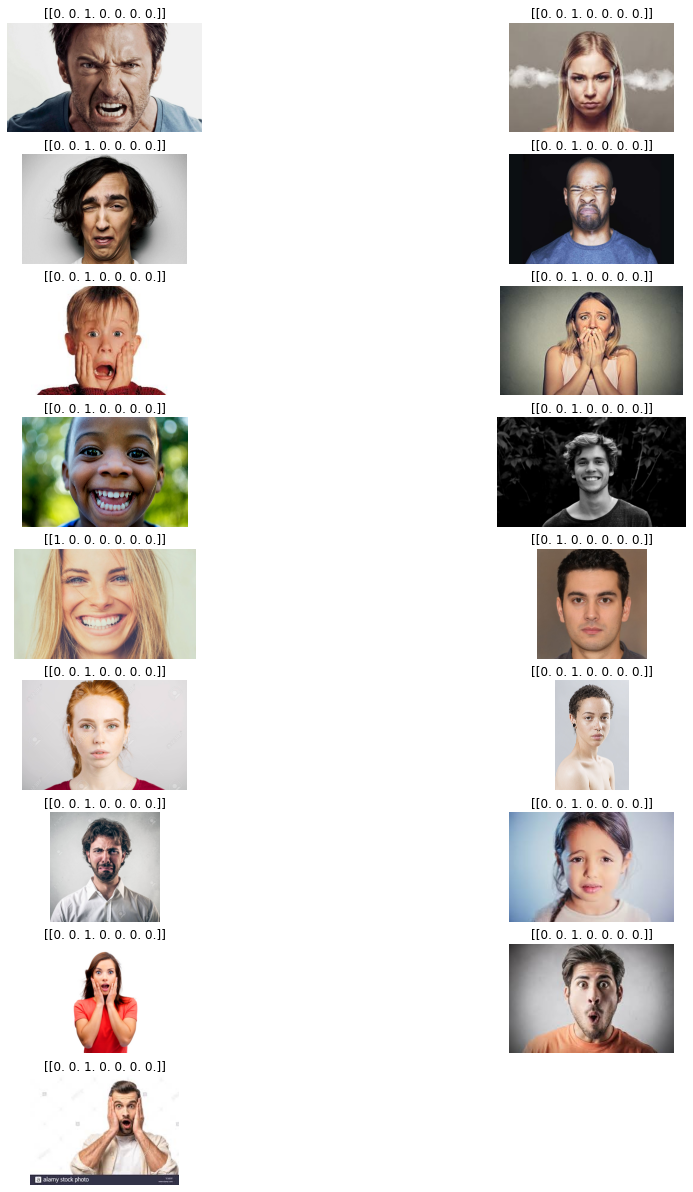

In [65]:
root_dir = "img_test"
dir_ = os.listdir(root_dir)

test_img_paths = [os.path.join(root_dir,x) for x in dir_]
rows = len(dir_)

fig = plt.gcf()
fig.set_size_inches(16,48)
for i, img in enumerate(test_img_paths):
    img_load_for_test = image.load_img(img, target_size=(256,256))
    img_test = image.img_to_array(img_load_for_test)
    img_test = np.expand_dims(img_test, axis=0)
    title = model.predict(img_test)

    img_plot = mpimg.imread(img)
    sb = plt.subplot(20,2,i+1)
    sb.set_title(str(title))
    sb.axis("off")
    img_plot = mpimg.imread(img)
    plt.imshow(img_plot)
plt.show()


In [ ]:

import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
abc = "emotions/test/anger"
abc_li = os.listdir(abc)
xyz = [os.path.join(abc, f) for f in abc_li]


img_path = random.choice(xyz)
img = load_img(img_path, target_size=(256, 256))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
fig = plt.gcf()
fig.set_size_inches(16,48)
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

In [ ]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")

